# BCPNN rule

In [33]:
import sys
sys.path.append('../')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

plt.rcParams["figure.figsize"] = [16,9]
sns.set(font_scale=3.0)

from network import run_network_recall, train_network
from connectivity import designed_matrix_sequences
from analysis import get_recall_duration_for_pattern, get_recall_duration_sequence

In [47]:
def get_w_pre_post(P, p_pre, p_post, p=1.0, epsilon=1e-20, diagonal_zero=True):

    outer = np.outer(p_post, p_pre)
    w = log_epsilon(p * P, epsilon) - log_epsilon(outer, epsilon)
   
    # x = p * (P / outer)
    # w = np.log(x)
    #w = log_epsilon(x, epsilon)

    if diagonal_zero:
        w[np.diag_indices_from(w)] = 0
        
    return w

In [48]:
def log_epsilon(x, epsilon=1e-10):

    return np.log(np.maximum(x, epsilon))

In [68]:
def train_network_BCPNN(N, dt, training_time, inter_sequence_time, sequences, tau_z, tau_z_post, tau_p,
                        epochs=1, max_w=1.0, min_w=None, save_w_history=False):

    w = np.zeros((N, N))
    w_history = [w]

    inter_sequence_steps = int(inter_sequence_time / dt)

    x_total = np.array([]).reshape(0, N)
    for epoch in range(epochs):
        for sequence in sequences:
            n_sequence = len(sequence)
            training_steps = int(training_time / dt)

            for element in sequence:
                x = np.zeros((training_steps, N))
                for time in range(training_steps):
                    x[time, element] = 1.0
                # Concatenate for the total history
                x_total = np.concatenate((x_total, x), axis=0)

            # Inter-sequence steps
            x = np.zeros((inter_sequence_steps, N))
            x_total = np.concatenate((x_total, x), axis=0)

    # Train the Z-filters and w
    z = np.zeros(N)
    z_post = np.zeros(N)
    z_co = np.zeros((N, N))
    p_pre = np.zeros(N) * (1.0 / N)
    p_post = np.zeros(N) * (1.0 / N)
    p_co = np.zeros((N, N)) * (1.0 / N)

    z_history = np.zeros_like(x_total)
    z_post_history = np.zeros_like(x_total)

    for index, x_example in enumerate(x_total):
        z += (dt / tau_z) * (x_example - z)
        z_post += (dt / tau_z_post) * (x_example - z_post)
        p_pre += (dt/ tau_p) * (z - p_pre)
        p_post += (dt/ tau_p) * (z_post - p_post)
        
        z_co = np.outer(z_post, z)
        p_co += (dt / tau_p) * (z_co - p_co)
        
        p = 1.0
        epsilon = 1e-10
        aux = get_w_pre_post(p_co, p_pre, p_post, p=p, epsilon=epsilon, diagonal_zero=False)
        print(aux)
        w = aux
        
        z_history[index, :] = z
        z_post_history[index, :] = z_post

        

        if save_w_history:
            w_history.append(np.copy(w))


    dic = {}
    dic['w'] = w
    dic['x'] = x_total
    dic['z'] = z_history
    dic['z_post'] = z_post_history

    if save_w_history:
        dic['w_history'] = np.array(w_history)

    return dic

In [69]:
N = 10
dt = 0.001
training_time = 0.100
inter_sequence_time = 0.500
sequences = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
tau_z = 0.050
tau_z_post= 0.005
tau_p = 10.0

dic = train_network_BCPNN(N, dt, training_time, inter_sequence_time, sequences, tau_z, tau_z_post, tau_p,
                        epochs=3, max_w=1.0, min_w=None, save_w_history=False)

[[ 8.29404964  0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0

   0.          0.          0.        ]]
[[ 4.58637641  3.84959453  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 4.88115993  7.75449031  0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.       

[[  4.14899554  -0.67213021 -10.75905586   0.           0.           0.
    0.           0.           0.           0.        ]
 [  3.5779157    4.41571451   2.02416222   0.           0.           0.
    0.           0.           0.           0.        ]
 [  2.22656874   4.51351553   6.18747201   0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.
    0.           0.           0.       

[[  4.12862983  -0.95590959 -13.65743528 -12.57518607   0.           0.
    0.           0.           0.           0.        ]
 [  3.55735788   4.13189222  -0.86091463 -12.58518657   0.           0.
    0.           0.           0.           0.        ]
 [  1.53708717   3.56062029   4.22688719   0.22133127   0.           0.
    0.           0.           0.           0.        ]
 [ -0.1969206    1.82661252   3.94187821   5.07385478   0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.
    0.           0.           0.       

[[  4.13916285  -0.95755152 -13.74351258 -13.69040044 -13.05429477   0.
    0.           0.           0.           0.        ]
 [  3.5678909    4.13025029  -0.95939256 -13.70040094 -13.06429527   0.
    0.           0.           0.           0.        ]
 [  1.54762017   3.55897834   4.12840925  -0.90628042 -13.07429577   0.
    0.           0.           0.           0.        ]
 [ -0.47265056   1.53870761   3.5571373    4.18152139  -0.27017476   0.
    0.           0.           0.           0.        ]
 [ -2.39214573  -0.38078756   1.63764214   3.71102501   4.75269353   0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.
    0.           0.           0.       

[[  4.14613539  -0.951406   -13.73647617 -13.73179786 -13.62482574
  -12.42663152   0.           0.           0.           0.        ]
 [  3.57486344   4.13639581  -0.9594565  -13.74179836 -13.63482624
  -12.43663202   0.           0.           0.           0.        ]
 [  1.55459271   3.56512386   4.12834531  -0.95477819 -13.64482674
  -12.44663252   0.           0.           0.           0.        ]
 [ -0.46567802   1.54485313   3.55707336   4.13302362  -0.84780607
  -12.45663302   0.           0.           0.           0.        ]
 [ -2.48594871  -0.47541756   1.53680267   3.56175172   4.23999577
    0.35037841   0.           0.           0.           0.        ]
 [ -4.17899774  -2.16846659  -0.15624636   1.86870268   3.99594554
    5.15596002   0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.     

    0.00000000e+00   0.00000000e+00]]
[[  4.16429699e+00  -9.33498602e-01  -1.37022677e+01  -1.37118935e+01
   -1.37190923e+01  -1.37079252e+01  -1.35439204e+01  -1.18179263e+01
    0.00000000e+00   0.00000000e+00]
 [  3.59302504e+00   4.15430321e+00  -9.43448920e-01  -1.37218940e+01
   -1.37290928e+01  -1.37179257e+01  -1.35539209e+01  -1.18279268e+01
    0.00000000e+00   0.00000000e+00]
 [  1.57275431e+00   3.58303126e+00   4.14435289e+00  -9.53074718e-01
   -1.37390933e+01  -1.37279262e+01  -1.35639214e+01  -1.18379273e+01
    0.00000000e+00   0.00000000e+00]
 [ -4.47516422e-01   1.56276053e+00   3.57308094e+00   4.13472709e+00
   -9.60273494e-01  -1.37379267e+01  -1.35739219e+01  -1.18479278e+01
    0.00000000e+00   0.00000000e+00]
 [ -2.46778715e+00  -4.57510201e-01   1.55281021e+00   3.56345515e+00
    4.12752832e+00  -9.49106399e-01  -1.35839224e+01  -1.18579283e+01
    0.00000000e+00   0.00000000e+00]
 [ -4.48805789e+00  -2.47778093e+00  -4.67460519e-01   1.54318442e+00
    3.5

[[  4.1746966   -0.92310488 -13.68151742 -13.69147162 -13.70112637
  -13.70854198 -13.69903136 -13.54993372 -11.96025468   0.        ]
 [  3.60342465   4.16469693  -0.93309918 -13.70147212 -13.71112687
  -13.71854248 -13.70903186 -13.55993422 -11.97025518   0.        ]
 [  1.58315392   3.59342498   4.15470263  -0.94305338 -13.72112737
  -13.72854298 -13.71903236 -13.56993472 -11.98025568   0.        ]
 [ -0.43711681   1.57315425   3.58343068   4.14474843  -0.95270813
  -13.73854348 -13.72903286 -13.57993522 -11.99025618   0.        ]
 [ -2.45738755  -0.44711648   1.56315995   3.57347649   4.13509368
   -0.96012374 -13.73903336 -13.58993572 -12.00025668   0.        ]
 [ -4.47765828  -2.46738721  -0.45711078   1.55320576   3.56382173
    4.12767807  -0.95061312 -13.59993622 -12.01025718   0.        ]
 [ -6.49792901  -4.48765795  -2.47738151  -0.46706498   1.543551
    3.55640612   4.13718869  -0.80151548 -12.02025768   0.        ]
 [ -8.51819875  -6.50792769  -4.49765125  -2.48733472  -0

[[  4.18579704  -0.91200519 -13.6593227  -13.66931823 -13.67928161
  -13.68900497 -13.69693409 -13.69133393 -13.57647695 -12.30349421]
 [  3.61452509   4.17579663  -0.92200502 -13.67931873 -13.68928211
  -13.69900547 -13.70693459 -13.70133443 -13.58647745 -12.31349471]
 [  1.59425436   3.60452468   4.16579679  -0.93200055 -13.69928261
  -13.70900597 -13.71693509 -13.71133493 -13.59647795 -12.32349521]
 [ -0.42601637   1.58425395   3.59452485   4.15580126  -0.94196393
  -13.71900647 -13.72693559 -13.72133543 -13.60647845 -12.33349571]
 [ -2.4462871   -0.43601678   1.57425411   3.58452932   4.14583788
   -0.95168729 -13.73693609 -13.73133593 -13.61647895 -12.34349621]
 [ -4.46655784  -2.45628752  -0.44601662   1.56425859   3.57456594
    4.13611452  -0.9596164  -13.74133643 -13.62647945 -12.35349671]
 [ -6.48682857  -4.47655825  -2.46628735  -0.45601215   1.5542952
    3.56484258   4.12818541  -0.95401625 -13.63647995 -12.36349721]
 [ -8.5070993   -6.49682898  -4.48655808  -2.47628288  -

[[  4.19599753  -0.90180476 -13.63892235 -13.64892221 -13.65891794
  -13.66888278 -13.67861706 -13.68662792 -13.6816486  -13.57210952]
 [  3.62472559   4.18599705  -0.91180518 -13.65892271 -13.66891844
  -13.67888328 -13.68861756 -13.69662842 -13.6916491  -13.58211002]
 [  1.60445486   3.6147251    4.17599663  -0.92180504 -13.67891894
  -13.68888378 -13.69861806 -13.70662892 -13.7016496  -13.59211052]
 [ -0.41581588   1.59445437   3.60472469   4.16599677  -0.93180076
  -13.69888428 -13.70861857 -13.71662942 -13.7116501  -13.60211102]
 [ -2.43608661  -0.42581636   1.58445395   3.59472483   4.15600105
   -0.94176561 -13.71861907 -13.72662992 -13.7216506  -13.61211152]
 [ -4.45635734  -2.4460871   -0.43581678   1.57445409   3.5847291
    4.1460362   -0.95149989 -13.73663042 -13.7316511  -13.62211202]
 [ -6.47662807  -4.46635783  -2.45608751  -0.44581664   1.56445837
    3.57476426   4.13630192  -0.95951074 -13.7416516  -13.63211252]
 [ -8.4968988   -6.48662856  -4.47635824  -2.46608737  -

[[  4.20819814  -0.88960417 -13.61452122 -13.62452167 -13.63452176
  -13.64451919 -13.65449678 -13.66432622 -13.6730488  -13.67345726]
 [  3.6369262    4.19819764  -0.89960466 -13.63452217 -13.64452226
  -13.65451969 -13.66449728 -13.67432672 -13.6830493  -13.68345776]
 [  1.61665547   3.6269257    4.18819715  -0.9096051  -13.65452276
  -13.66452019 -13.67449778 -13.68432722 -13.6930498  -13.69345826]
 [ -0.40361527   1.60665497   3.61692521   4.17819671  -0.91960519
  -13.67452069 -13.68449828 -13.69432772 -13.7030503  -13.70345876]
 [ -2.423886    -0.41361577   1.59665447   3.60692476   4.16819662
   -0.92960262 -13.69449878 -13.70432822 -13.7130508  -13.71345926]
 [ -4.44415673  -2.4338865   -0.42361626   1.58665403   3.59692467
    4.15819919  -0.93958021 -13.71432872 -13.7230513  -13.72345976]
 [ -6.46442746  -4.45415723  -2.44388699  -0.4336167    1.57665394
    3.58692724   4.1482216   -0.94940966 -13.7330518  -13.73346026]
 [ -8.48469819  -6.47442796  -4.46415772  -2.45388744  

[[  4.21689858  -0.88090373 -13.59712036 -13.60712085 -13.61712128
  -13.62712125 -13.63711776 -13.64708851 -13.65686685 -13.66520735]
 [  3.64562663   4.20689808  -0.89090423 -13.61712135 -13.62712178
  -13.63712175 -13.64711826 -13.65708901 -13.66686735 -13.67520785]
 [  1.6253559    3.63562613   4.19689758  -0.90090472 -13.63712228
  -13.64712225 -13.65711876 -13.66708951 -13.67686785 -13.68520835]
 [ -0.39491483   1.6153554    3.62562563   4.18689709  -0.91090515
  -13.65712275 -13.66711926 -13.67709001 -13.68686835 -13.69520885]
 [ -2.41518556  -0.40491533   1.6053549    3.61562514   4.17689666
   -0.92090512 -13.67711976 -13.68709051 -13.69686885 -13.70520935]
 [ -4.4354563   -2.42518606  -0.41491583   1.59535441   3.60562471
    4.16689669  -0.93090163 -13.69709101 -13.70686935 -13.71520985]
 [ -6.45572703  -4.4454568   -2.43518656  -0.42491632   1.58535398
    3.59562475   4.15690018  -0.94087238 -13.71686985 -13.72521035]
 [ -8.47599776  -6.46572753  -4.45545729  -2.44518705  

[[  4.23319939  -0.86460292 -13.56451873 -13.57451923 -13.58451973
  -13.59452021 -13.60452056 -13.61451994 -13.62451205 -13.63444995]
 [  3.66192745   4.22319889  -0.87460342 -13.58451973 -13.59452023
  -13.60452071 -13.61452106 -13.62452044 -13.63451255 -13.64445045]
 [  1.64165671   3.65192695   4.21319839  -0.88460392 -13.60452073
  -13.61452121 -13.62452156 -13.63452094 -13.64451305 -13.65445095]
 [ -0.37861402   1.63165621   3.64192645   4.20319789  -0.89460441
  -13.62452171 -13.63452206 -13.64452144 -13.65451355 -13.66445145]
 [ -2.39888475  -0.38861452   1.62165571   3.63192595   4.1931974
   -0.90460489 -13.64452256 -13.65452194 -13.66451405 -13.67445195]
 [ -4.41915548  -2.40888525  -0.39861502   1.61165522   3.62192545
    4.18319692  -0.91460524 -13.66452244 -13.67451455 -13.68445245]
 [ -6.43942621  -4.42915598  -2.41888575  -0.40861552   1.60165472
    3.61192497   4.17319657  -0.92460462 -13.68451505 -13.69445295]
 [ -8.45969694  -6.44942671  -4.43915648  -2.42888625  -

[[  4.01499153  -1.13538891 -13.82530422 -13.83530472 -13.84530522
  -13.85530572 -13.37507249 -11.36480211  -9.35453075  -7.34425214]
 [  3.57666626   4.23319939  -0.86460292 -13.56451873 -13.57451923
  -13.58451973 -13.59452021 -13.60452056 -13.61451994 -13.62451205]
 [  1.55639553   3.66192745   4.22319889  -0.87460342 -13.58451973
  -13.59452023 -13.60452071 -13.61452106 -13.62452044 -13.63451255]
 [ -0.46387521   1.64165671   3.65192695   4.21319839  -0.88460392
  -13.60452073 -13.61452121 -13.62452156 -13.63452094 -13.64451305]
 [ -2.48414594  -0.37861402   1.63165621   3.64192645   4.20319789
   -0.89460441 -13.62452171 -13.63452206 -13.64452144 -13.65451355]
 [ -4.50441667  -2.39888475  -0.38861452   1.62165571   3.63192595
    4.1931974   -0.90460489 -13.64452256 -13.65452194 -13.66451405]
 [ -6.5246874   -4.41915548  -2.40888525  -0.39861502   1.61165522
    3.62192545   4.18319692  -0.91460524 -13.66452244 -13.67451455]
 [ -8.54495813  -6.43942621  -4.42915598  -2.41888575  

[[  3.59828362  -0.96646276 -14.29447213 -14.30447263 -14.31447313
  -14.32447363 -13.16068985 -11.1504196   -9.14014923  -7.12987798]
 [  3.20607322   3.98753844  -1.17772447 -13.86713976 -13.87714026
  -13.88714076 -13.89714126 -13.29930325 -11.28903288  -9.27876163]
 [  1.00673879   3.55092411   4.23369942  -0.86410289 -13.56351868
  -13.57351918 -13.58351968 -13.59352016 -13.60352053 -13.61352001]
 [ -1.01353194   1.53065338   3.66242747   4.22369892  -0.87410339
  -13.58351968 -13.59352018 -13.60352066 -13.61352103 -13.62352051]
 [ -3.03380268  -0.48961735   1.64215674   3.65242697   4.21369842
   -0.88410389 -13.60352068 -13.61352116 -13.62352153 -13.63352101]
 [ -5.05407341  -2.50988808  -0.37811399   1.63215624   3.64242647
    4.20369792  -0.89410439 -13.62352166 -13.63352203 -13.64352151]
 [ -7.07434414  -4.53015881  -2.39838472  -0.38811449   1.62215574
    3.63242597   4.19369742  -0.90410487 -13.64352253 -13.65352201]
 [ -9.09461487  -6.55042954  -4.41865546  -2.40838522  

[[  3.50446918  -1.52873386 -14.51651179 -14.28027705 -14.29027755
  -14.30027805 -13.14859336 -11.13832312  -9.12805288  -7.11778256]
 [  2.93319728   3.55906798  -1.08824702 -14.2902775  -14.300278
  -14.3102785  -14.320279   -13.15859381 -11.14832357  -9.13805325]
 [  1.06352656   3.13839606   3.89035375  -1.33808865 -14.02540383
  -14.03540433 -14.04540483 -14.05540533 -13.15002823 -11.13975791]
 [ -1.10734423   0.96752527   3.42829284   4.23579952  -0.86200279
  -13.55931847 -13.56931897 -13.57931947 -13.58931996 -13.59932037]
 [ -3.12761496  -1.05274546   1.4080221    3.66452758   4.22579902
   -0.87200329 -13.57931947 -13.58931997 -13.59932046 -13.60932087]
 [ -5.14788569  -3.07301619  -0.61224863   1.64425685   3.65452708
    4.21579852  -0.88200379 -13.59932047 -13.60932096 -13.61932137]
 [ -7.16815642  -5.09328692  -2.63251936  -0.37601389   1.63425634
    3.64452658   4.20579802  -0.89200429 -13.61932146 -13.62932187]
 [ -9.18842715  -7.11355765  -4.65279009  -2.39628462  -0

[[  3.50597766  -1.58313562 -14.94424207 -14.49440621 -14.27067657
  -14.28067707 -13.13879287 -11.12852263  -9.1182524   -7.10798216]
 [  2.93470571   3.50466619  -1.5257678  -14.50440671 -14.28067707
  -14.29067757 -14.30067807 -13.14879337 -11.13852313  -9.12825289]
 [  0.91443506   2.93339432   3.56203406  -1.07594729 -14.29067749
  -14.30067799 -14.31067849 -14.32067899 -13.1587938  -11.14852355]
 [ -0.95068103   1.06827824   3.14591679   3.89873524  -1.32388997
  -14.01140517 -14.02140567 -14.03140617 -14.04140666 -13.15684852]
 [ -3.12610648  -1.10714722   0.97049133   3.44059793   4.23559951
   -0.8622028  -13.55971849 -13.56971899 -13.57971949 -13.58971998]
 [ -5.14637721  -3.12741795  -1.0497794    1.4203272    3.66432757
    4.22559901  -0.8722033  -13.57971949 -13.58971999 -13.59972048]
 [ -7.16664795  -5.14768868  -3.07005013  -0.59994353   1.64405684
    3.65432707   4.21559851  -0.8822038  -13.59972049 -13.60972098]
 [ -9.18691868  -7.16795941  -5.09032086  -2.62021426  

   -2.39488455  -0.38461432   1.62565591   3.63592615   4.19719759]]
[[  3.51646822  -1.58051134 -14.99112189 -14.95386753 -14.5886897
  -14.2572759  -13.12709228 -11.11682205  -9.10655182  -7.09628158]
 [  2.94519627   3.50729047  -1.5843482  -14.96386803 -14.5986902
  -14.2672764  -14.2772769  -13.13709278 -11.12682255  -9.11655232]
 [  0.92492554   2.93601853   3.50345361  -1.54709384 -14.6086907
  -14.2772769  -14.2872774  -14.2972779  -13.14709328 -11.13682305]
 [ -1.09534519   0.9157478    2.93218167   3.54070797  -1.1819164
  -14.2872774  -14.2972779  -14.3072784  -14.3172789  -13.15709378]
 [ -3.00664385  -0.99555086   1.02088301   3.0784081    3.83091919
   -1.43852027 -14.12433538 -14.13433588 -14.14433638 -14.15433688]
 [ -5.13588666  -3.12479367  -1.1083598    0.9491653    3.33461385
    4.2372996   -0.86050271 -13.55631832 -13.56631882 -13.57631932]
 [ -7.15615739  -5.1450644   -3.12863053  -1.07110544   1.31434312
    3.66602765   4.2272991   -0.87050321 -13.57631932 -13.

[[  3.52985012  -1.56789768 -14.9707642  -14.97772112 -14.96470276
  -14.78374061 -13.12147209 -11.10332137  -9.09305114  -7.08278091]
 [  2.95857818   3.51990413  -1.57749119 -14.98772162 -14.97470326
  -14.79374111 -14.25815604 -13.12359211 -11.11332187  -9.10305164]
 [  0.93830745   2.94863218   3.51031062  -1.58444811 -14.98470376
  -14.80374161 -14.26815654 -14.27027655 -13.13359261 -11.12332237]
 [ -1.08196329   0.92836145   2.93903868   3.5033537   -1.57142975
  -14.81374211 -14.27815704 -14.28027705 -14.29027755 -13.14359311]
 [ -3.10223402  -1.09190928   0.91876794   2.93208175   3.51637206
   -1.39046759 -14.28815754 -14.29027755 -14.30027805 -14.31027855]
 [ -5.1198161   -3.10949136  -1.09881414   0.91449967   2.94778876
    3.69693463  -1.10248372 -14.29664366 -14.30664416 -14.31664466]
 [ -7.07881757  -5.06849283  -3.05781561  -1.0445018    0.98878729
    3.19002018   4.18928967  -0.90959886 -13.60191429 -13.61191479]
 [ -9.16304621  -7.15272148  -5.14204425  -3.12873044  

   -3.1244187   -1.01114172   1.53595081   3.66232747   4.22359891]]
[[  3.54274297  -1.55505527 -14.94539771 -14.95517104 -14.96347401
  -14.96070998 -13.75610991 -11.21192459  -9.0801505   -7.06988027]
 [  2.97147102   3.53274654  -1.56502534 -14.96517154 -14.97347451
  -14.97071048 -14.87989321 -13.23219532 -11.10042123  -9.090151  ]
 [  0.95120029   2.9614746    3.52277647  -1.57479867 -14.98347501
  -14.98071098 -14.88989371 -14.36597912 -13.12069196 -11.11042173]
 [ -1.06907044   0.94120387   2.95150453   3.51300314  -1.58310164
  -14.99071148 -14.89989421 -14.37597962 -14.26447626 -13.13069246]
 [ -3.08934117  -1.07906686   0.93123379   2.9417312    3.50470017
   -1.58033761 -14.90989471 -14.38598012 -14.27447676 -14.28447726]
 [ -5.1096119   -3.0993376   -1.08903694   0.92146046   2.93342823
    3.5074642   -1.48952034 -14.39598062 -14.28447726 -14.29447776]
 [ -7.12987782  -5.11960351  -3.10930286  -1.09880546   0.91316231
    2.93619707   3.59828362  -0.96646276 -14.29447213 

   -3.12639445  -1.10670314   0.9768519    3.46494262   4.23519949]]
[[  3.55434298  -1.54345893 -14.92222827 -14.93220671 -14.94204253
  -14.95081277 -13.8493986  -11.76737189  -9.2836836   -7.05827969]
 [  2.98307103   3.54434288  -1.55345648 -14.94220721 -14.95204303
  -14.96081327 -14.96158132 -13.78764262 -11.30395434  -9.07855042]
 [  0.9628003    2.97307093   3.53434533  -1.56343492 -14.96204353
  -14.97081377 -14.97158182 -14.90982584 -13.32422507 -11.09882115]
 [ -1.05747043   0.9528002    2.96307338   3.52436689  -1.57327074
  -14.98081427 -14.98158232 -14.91982634 -14.45640879 -13.11909188]
 [ -3.07774116  -1.06747053   0.94280265   2.95309494   3.51453107
   -1.58204098 -14.99158282 -14.92982684 -14.46640929 -14.2612761 ]
 [ -5.09801189  -3.08774127  -1.07746808   0.93282421   2.94325912
    3.50576083  -1.58280903 -14.93982734 -14.47640979 -14.2712766 ]
 [ -7.11828262  -5.108012    -3.09773881  -1.08744652   0.92298839
    2.93448888   3.50499278  -1.52105305 -14.48641029 

   -2.95257541  -0.9410244    1.07885943   3.16397692   3.92032785]]
[[  3.56424342  -1.53355883 -14.90243022 -14.91242771 -14.9224057
  -14.93223818 -13.84870169 -11.82901037  -9.74545534  -7.25736462]
 [  2.99297148   3.55424298  -1.54355893 -14.92242821 -14.9324062
  -14.94223868 -14.95098391 -13.8492811  -11.76572607  -9.27763535]
 [  0.97270074   2.98297103   3.54424288  -1.55355642 -14.9424067
  -14.95223918 -14.96098441 -14.96156383 -13.7859968  -11.29790609]
 [ -1.04756999   0.9627003    2.97297093   3.53424539  -1.56353441
  -14.96223968 -14.97098491 -14.97156433 -14.90828002 -13.31817682]
 [ -3.06784072  -1.05757043   0.9527002    2.96297345   3.5242674
   -1.57336688 -14.98098541 -14.98156483 -14.91828052 -14.45046054]
 [ -5.08811145  -3.07784116  -1.06757053   0.94270272   2.95299545
    3.51443493  -1.58211212 -14.99156533 -14.92828102 -14.46046104]
 [ -7.10838218  -5.0981119   -3.08784126  -1.07756801   0.93272472
    2.94316298   3.50568969  -1.58269154 -14.93828152 -14.

[[  3.57474394  -1.52305836 -14.88142958 -14.89142972 -14.90142749
  -14.91140764 -13.83947498 -11.82806961  -9.80928424  -7.73304537]
 [  3.00347199   3.56474345  -1.53305881 -14.90143022 -14.91142799
  -14.92140814 -14.93125668 -13.84834034 -11.82955497  -9.7533161 ]
 [  0.98320126   2.9934715    3.554743    -1.54305895 -14.92142849
  -14.93140864 -14.94125718 -14.95012254 -13.84982571 -11.77358683]
 [ -1.03706947   0.97320077   2.98347105   3.54474286  -1.55305672
  -14.94140914 -14.95125768 -14.96012304 -14.96160841 -13.79385756]
 [ -3.0573402   -1.04706996   0.96320032   2.97347091   3.53474509
   -1.56303687 -14.96125818 -14.97012354 -14.97160891 -14.91564076]
 [ -5.07761093  -3.06734069  -1.05707041   0.95320018   2.96347314
    3.52476494  -1.57288541 -14.98012404 -14.98160941 -14.92564126]
 [ -7.09788166  -5.08761143  -3.07734115  -1.06707055   0.94320241
    2.95349299   3.5149164   -1.58175078 -14.99160991 -14.93564176]
 [ -9.1181524   -7.10788216  -5.09761188  -3.08734128  

   -3.0993376   -1.08903694   0.92146046   2.93342823   3.5074642 ]]
[[  3.58284434  -1.51495796 -14.86522882 -14.87522925 -14.88522921
  -14.89522572 -13.8315156  -11.82102272  -9.80908878  -7.78631015]
 [  3.0115724    3.57284385  -1.52495846 -14.88522975 -14.89522971
  -14.90522622 -14.9151969  -13.84129345 -11.82935951  -9.80658088]
 [  0.99130167   3.0015719    3.56284336  -1.53495888 -14.90523021
  -14.91522672 -14.9251974  -14.93497525 -13.84963024 -11.82685161]
 [ -1.02896906   0.98130117   2.99157141   3.55284293  -1.54495885
  -14.92522722 -14.9351979  -14.94497575 -14.95331254 -13.84712234]
 [ -3.0492398   -1.03896956   0.97130068   2.98157098   3.54284296
   -1.55495535 -14.9451984  -14.95497625 -14.96331304 -14.96080514]
 [ -5.06951053  -3.0592403   -1.04897005   0.96130025   2.97157102
    3.53284646  -1.56492603 -14.96497675 -14.97331354 -14.97080564]
 [ -7.08978126  -5.07951103  -3.06924079  -1.05897048   0.95130028
    2.96157451   3.52287578  -1.57470389 -14.98331404 

[[  3.59734507  -1.50045724 -14.83622738 -14.84622787 -14.85622835
  -14.86622863 -13.81704744 -11.80676514  -9.79640481  -7.78546172]
 [  3.02607312   3.58734457  -1.51045774 -14.85622837 -14.86622885
  -14.87622913 -14.88622801 -13.82703587 -11.81667555  -9.80573246]
 [  1.00580239   3.01607262   3.57734407  -1.52045824 -14.87622935
  -14.88622963 -14.89622851 -14.90621694 -13.83694628 -11.82600319]
 [ -1.01446834   0.99580189   3.00607212   3.56734357  -1.53045871
  -14.89623013 -14.90622901 -14.91621744 -14.92612785 -13.84627392]
 [ -3.03473907  -1.02446884   0.98580139   2.99607163   3.5573431
   -1.54045899 -14.91622951 -14.92621794 -14.93612835 -14.94545599]
 [ -5.0550098   -3.04473957  -1.03446934   0.9758009    2.98607116
    3.54734282  -1.55045787 -14.93621844 -14.94612885 -14.95545649]
 [ -7.07528054  -5.0650103   -3.05474007  -1.04446984   0.96580043
    2.97607087   3.53734394  -1.56044631 -14.95612935 -14.96545699]
 [ -9.09555127  -7.08528104  -5.0750108   -3.06474057  -

[[  3.60894565  -1.48885666 -14.81302622 -14.82302672 -14.83302722
  -14.84302769 -13.80544855 -11.79517714  -9.78489816  -7.77456262]
 [  3.0376737    3.59894515  -1.49885716 -14.83302722 -14.84302772
  -14.85302819 -14.86302854 -13.81544788 -11.8051689   -9.79483335]
 [  1.01740297   3.0276732    3.58894465  -1.50885766 -14.85302822
  -14.86302869 -14.87302904 -14.88302837 -13.82543963 -11.81510408]
 [ -1.00286776   1.00740247   3.0176727    3.57894415  -1.51885816
  -14.87302919 -14.88302954 -14.89302887 -14.90302062 -13.83537481]
 [ -3.02313849  -1.01286826   0.99740197   3.0076722    3.56894365
   -1.52885864 -14.89303004 -14.90302937 -14.91302112 -14.9229563 ]
 [ -5.04340922  -3.03313899  -1.02286876   0.98740147   2.99767171
    3.55894317  -1.53885898 -14.91302987 -14.92302162 -14.9329568 ]
 [ -7.06367996  -5.05340972  -3.04313949  -1.03286926   0.97740097
    2.98767123   3.54894283  -1.54885831 -14.93302212 -14.9429573 ]
 [ -9.08395069  -7.07368046  -5.06341022  -3.05313999  

[[  3.6126089   -1.48494476 -14.7987138  -14.8087143  -14.8187148
  -14.82871529 -13.77251439 -11.76224401  -9.7519727   -7.74169439]
 [  3.0473423    3.60934567  -1.48845664 -14.81222618 -14.82222668
  -14.83222718 -14.84222766 -13.80504854 -11.79477723  -9.78449892]
 [  1.02707157   3.03807372   3.59934517  -1.49845714 -14.83222718
  -14.84222768 -14.85222816 -14.86222851 -13.81504796 -11.80476966]
 [ -0.99319916   1.01780299   3.02807322   3.58934467  -1.50845764
  -14.85222818 -14.86222866 -14.87222901 -14.88222843 -13.82504039]
 [ -3.01346989  -1.00246774   1.00780249   3.01807272   3.57934417
   -1.51845814 -14.87222916 -14.88222951 -14.89222893 -14.90222136]
 [ -5.03374063  -3.02273847  -1.01246824   0.99780199   3.00807222
    3.56934367  -1.52845862 -14.89223001 -14.90222943 -14.91222186]
 [ -7.05401136  -5.0430092   -3.03273897  -1.02246874   0.98780149
    2.99807173   3.55934319  -1.53845897 -14.91222993 -14.92222236]
 [ -9.07428209  -7.06327994  -5.0530097   -3.04273947  -

[[  3.21087937  -1.57433104 -15.24796893 -15.25796943 -15.26796993
  -15.27797043 -13.49453165 -11.48426141  -9.47399112  -7.46372047]
 [  2.74965662   3.4362214   -1.72564071 -15.03470951 -15.04471001
  -15.05471051 -15.06471101 -13.44809963 -11.43782934  -9.42755869]
 [  0.61933658   2.94223846   3.6140459   -1.48375641 -14.80282571
  -14.81282621 -14.82282671 -14.8328272  -13.80034841 -11.79007776]
 [ -1.40093416   0.92196773   3.04277396   3.6040454   -1.49375691
  -14.82282671 -14.83282721 -14.8428277  -14.85282814 -13.81034849]
 [ -3.42120489  -1.098303     1.02250323   3.03277346   3.5940449
   -1.50375741 -14.84282771 -14.8528282  -14.86282864 -14.87282872]
 [ -5.44147562  -3.11857373  -0.99776751   1.01250273   3.02277296
    3.5840444   -1.5137579  -14.8628287  -14.87282914 -14.88282922]
 [ -7.46174635  -5.13884446  -3.01803824  -1.00776801   1.00250223
    3.01277246   3.57404391  -1.5237584  -14.88282964 -14.89282972]
 [ -9.48201708  -7.15911519  -5.03830897  -3.02803874  -

   -3.03553911  -1.02526888   0.98500135   2.99527159   3.55654307]]
[[  3.16628667  -1.90001669 -15.4324447  -15.23276839 -15.24276889
  -15.25276939 -13.48193121 -11.47166097  -9.46139074  -7.45112047]
 [  2.59501473   3.18778512  -1.67083223 -15.24276889 -15.25276939
  -15.26276989 -15.27277039 -13.4919317  -11.48166147  -9.4713912 ]
 [  0.6435019    2.68527108   3.37151664  -1.84198799 -15.14845666
  -15.15845716 -15.16845766 -15.17845816 -13.45190518 -11.44163491]
 [ -1.44552674   0.59624245   2.84569778   3.61664603  -1.48115628
  -14.79762545 -14.80762595 -14.81762645 -14.82762694 -13.79774831]
 [ -3.46579747  -1.42402829   0.82542705   3.04537409   3.60664553
   -1.49115678 -14.81762645 -14.82762695 -14.83762744 -14.84762791]
 [ -5.4860682   -3.44429902  -1.19484368   1.02510336   3.03537359
    3.59664503  -1.50115728 -14.83762745 -14.84762794 -14.85762841]
 [ -7.50633893  -5.46456975  -3.21511441  -0.99516738   1.01510286
    3.02537309   3.58664453  -1.51115778 -14.85762844 

   -3.0232385   -1.01296827   0.99730197   3.0075722    3.56884365]]
[[  3.17420546  -1.92098897 -15.66061489 -15.50994995 -15.21816766
  -15.22816816 -13.46963059 -11.45936036  -9.44909013  -7.43881989]
 [  2.60293352   3.16681284  -1.91130289 -15.51995045 -15.22816816
  -15.23816866 -15.24816916 -13.47963109 -11.46936086  -9.45909062]
 [  0.58266279   2.59554089   3.17649892  -1.76063795 -15.23816866
  -15.24816916 -15.25816966 -15.26817016 -13.48963159 -11.47936136]
 [ -1.42415879   0.58871932   2.61867613   3.32062323  -1.93449722
  -15.23866577 -15.24866627 -15.25866677 -15.26866727 -13.48860376]
 [ -3.45787868  -1.44500057   0.58495624   2.75589191   3.61894615
   -1.47885616 -14.79302522 -14.80302572 -14.81302622 -14.82302672]
 [ -5.47814941  -3.4652713   -1.43531449   0.73562118   3.0476742
    3.60894565  -1.48885666 -14.81302622 -14.82302672 -14.83302722]
 [ -7.49842014  -5.48554203  -3.45558522  -1.28464955   1.02740347
    3.0376737    3.59894515  -1.49885716 -14.83302722 -

   -3.02825643  -1.00106767   1.00920256   3.01947279   3.58074424]]
[[  3.18574012  -1.91182413 -15.65745705 -15.65407589 -15.55808237
  -15.22314023 -13.45773    -11.44745976  -9.43718953  -7.4269193 ]
 [  2.61446817   3.17597768  -1.92004565 -15.66407639 -15.56808287
  -15.23314073 -15.22436797 -13.4677305  -11.45746026  -9.44719003]
 [  0.59419744   2.60470573   3.16775616  -1.91666449 -15.57808337
  -15.24314123 -15.23436847 -15.24436897 -13.477731   -11.46746076]
 [ -1.42607329   0.584435     2.59648422   3.17113732  -1.82067097
  -15.25314173 -15.24436897 -15.25436947 -15.26436997 -13.4877315 ]
 [ -3.44612447  -1.43561618   0.57643303   2.60008493   3.26715687
   -1.51349398 -15.25409054 -15.26409104 -15.27409154 -15.28409204]
 [ -5.38526321  -3.37475491  -1.3627057    0.66094619   2.77721045
    3.54582951  -1.56082321 -14.87309217 -14.88309267 -14.89309317]
 [ -7.48688549  -5.47637719  -3.46432798  -1.44067609   0.67558817
    3.03080104   3.61084574  -1.48695657 -14.80922603 

[[  3.19660796  -1.90116774 -15.63748044 -15.64599667 -15.64484641
  -15.56742455 -13.48569397 -11.43655922  -9.42628899  -7.41601876]
 [  2.62533602   3.18663407  -1.91096958 -15.65599717 -15.65484691
  -15.57742505 -15.2414314  -13.45682995 -11.44655972  -9.43628949]
 [  0.60506529   2.61536213   3.17683223  -1.91948581 -15.66484741
  -15.58742555 -15.2514319  -15.22256788 -13.46683045 -11.45656022]
 [ -1.41520545   0.59509139   2.60556028   3.168316    -1.91833555
  -15.59742605 -15.2614324  -15.23256838 -15.24256888 -13.47683095]
 [ -3.43547618  -1.42517934   0.58528955   2.59704405   3.16946626
   -1.84091369 -15.2714329  -15.24256888 -15.25256938 -15.26256988]
 [ -5.45571609  -3.44541925  -1.43495037   0.57680414   2.59822513
    3.24689726  -1.50966408 -15.25253191 -15.26253241 -15.27253291]
 [ -7.37176463  -5.36146779  -3.3509989   -1.3392444    0.68217659
    2.77986918   3.50947418  -1.60981403 -14.92118295 -14.93118345]
 [ -9.49628837  -7.48599153  -5.47552265  -3.46376814  

[[  3.20510502  -1.89269247 -15.62066743 -15.63039935 -15.63839252
  -15.6332789  -13.78535561 -11.43699722  -9.41778856  -7.40751833]
 [  2.63383307   3.19510934  -1.902657   -15.64039985 -15.64839302
  -15.6432794  -15.53259261 -13.45726795 -11.43805929  -9.42778906]
 [  0.61356234   2.62383739   3.18514481  -1.91238892 -15.65839352
  -15.6532799  -15.54259311 -15.21450546 -13.45833003 -11.44805979]
 [ -1.40670839   0.60356666   2.61387286   3.17541289  -1.92038209
  -15.6632804  -15.55259361 -15.22450596 -15.22556803 -13.46833053]
 [ -3.42697912  -1.41670407   0.59360213   2.60414094   3.16741972
   -1.91526847 -15.56259411 -15.23450646 -15.23556853 -15.24556903]
 [ -5.44724985  -3.4369748   -1.4266686    0.58387021   2.59614778
    3.17253334  -1.80458168 -15.24450696 -15.24556903 -15.25556953]
 [ -7.46671236  -5.45643731  -3.44613111  -1.43559229   0.57668527
    2.60206962   3.28319504  -1.56122976 -15.25450573 -15.26450623]
 [ -9.43129191  -7.42101686  -5.41071065  -3.40017184  

   -3.46138137  -1.44527099   0.60971027   2.91010956   3.61494595]]
[[  3.21990505  -1.87789701 -15.59110537 -15.60109216 -15.61099034
  -15.62022665 -13.90206791 -11.84800229  -9.55033015  -7.39271759]
 [  2.64863311   3.2099048   -1.88789568 -15.61109266 -15.62099084
  -15.63022715 -15.63450417 -13.86827303 -11.57060088  -9.41298832]
 [  0.62836237   2.63863285   3.19990613  -1.89788247 -15.63099134
  -15.64022765 -15.64450467 -15.61070979 -13.59087161 -11.43325905]
 [ -1.39190836   0.61836212   2.62863419   3.18991934  -1.90778065
  -15.65022815 -15.65450517 -15.62071029 -15.34330888 -13.45352979]
 [ -3.41217909  -1.40190861   0.60836346   2.61864739   3.18002116
   -1.91701696 -15.66450567 -15.63071079 -15.35330938 -15.21596755]
 [ -5.43244982  -3.42217934  -1.41190728   0.59837666   2.60874921
    3.17078485  -1.92129398 -15.64071129 -15.36330988 -15.22596805]
 [ -7.45272055  -5.44245007  -3.43217801  -1.42189407   0.58847848
    2.59951291   3.16650783  -1.8874991  -15.37331038 

[[  3.22770541  -1.87009685 -15.57550627 -15.58550391 -15.59548308
  -15.60532434 -13.89949989 -11.88030402  -9.80075759  -7.45515065]
 [  2.65643347   3.21770496  -1.88009696 -15.59550441 -15.60548358
  -15.61532484 -15.62413576 -13.90057476 -11.82102832  -9.47542138]
 [  0.63616273   2.64643302   3.20770485  -1.89009461 -15.61548408
  -15.62532534 -15.63413626 -15.63521113 -13.84129906 -11.49569211]
 [ -1.384108     0.62616229   2.6364329    3.1977072   -1.90007378
  -15.63532584 -15.64413676 -15.64521163 -15.58593593 -13.51596285]
 [ -3.40437873  -1.39410845   0.61616217   2.62643526   3.18772803
   -1.90991504 -15.65413726 -15.65521213 -15.59593643 -15.27060022]
 [ -5.42464946  -3.41437918  -1.40410856   0.60616453   2.61645609
    3.17788677  -1.91872596 -15.66521263 -15.60593693 -15.28060072]
 [ -7.44492019  -5.43464991  -3.4243793   -1.41410621   0.59618535
    2.60661483   3.16907585  -1.91980083 -15.61593743 -15.29060122]
 [ -9.46519092  -7.45492064  -5.44465003  -3.43437694  

   -3.43827321  -1.42795626   0.58266279   2.59554089   3.17649892]]
[[  3.24390621  -1.85389609 -15.54310507 -15.55310546 -15.56310514
  -15.57309951 -13.88461966 -11.87400756  -9.86118144  -7.8316214 ]
 [  2.67263427   3.23390572  -1.86389658 -15.56310596 -15.57310564
  -15.58310001 -15.59305472 -13.89427829 -11.88145217  -9.85189213]
 [  0.65236354   2.66263377   3.22390523  -1.87389697 -15.58310614
  -15.59310051 -15.60305522 -15.61271385 -13.9017229  -11.87216287]
 [ -1.3679072    0.64236304   2.65263329   3.21390484  -1.88389665
  -15.60310101 -15.61305572 -15.62271435 -15.63015897 -13.8924336 ]
 [ -3.38817793  -1.37790769   0.63236255   2.6426329    3.20390516
   -1.89389101 -15.62305622 -15.63271485 -15.64015947 -15.63087016]
 [ -5.40844866  -3.39817842  -1.38790818   0.62236216   2.63263322
    3.1939108   -1.90384573 -15.64271535 -15.65015997 -15.64087066]
 [ -7.42871939  -5.41844916  -3.40817891  -1.39790857   0.61236248
    2.62263885   3.18395608  -1.91350436 -15.66016047 

   -3.42827896  -1.41800248   0.59231447   2.60293352   3.16681284]]
[[  3.25390671  -1.8438956  -15.52310409 -15.53310457 -15.54310496
  -15.55310464 -13.87466494 -11.86434893  -9.85373682  -7.84091071]
 [  2.68263477   3.24390621  -1.85389609 -15.54310507 -15.55310546
  -15.56310514 -15.57309951 -13.88461966 -11.87400756  -9.86118144]
 [  0.66236404   2.67263427   3.23390572  -1.86389658 -15.56310596
  -15.57310564 -15.58310001 -15.59305472 -13.89427829 -11.88145217]
 [ -1.3579067    0.65236354   2.66263377   3.22390523  -1.87389697
  -15.58310614 -15.59310051 -15.60305522 -15.61271385 -13.9017229 ]
 [ -3.37817743  -1.3679072    0.64236304   2.65263329   3.21390484
   -1.88389665 -15.60310101 -15.61305572 -15.62271435 -15.63015897]
 [ -5.39844816  -3.38817793  -1.37790769   0.63236255   2.6426329
    3.20390516  -1.89389101 -15.62305622 -15.63271485 -15.64015947]
 [ -7.41871889  -5.40844866  -3.39817842  -1.38790818   0.62236216
    2.63263322   3.1939108   -1.90384573 -15.64271535 -

   -3.41617924  -1.40590846   0.60436587   2.61466673   3.17616685]]
[[  3.26600732  -1.83179499 -15.49890288 -15.50890338 -15.51890387
  -15.5289043  -13.8625708  -11.85229655  -9.8419963   -7.83150194]
 [  2.69473537   3.25600682  -1.84179549 -15.51890388 -15.52890437
  -15.5389048  -15.54890476 -13.87256728 -11.86226703  -9.85177267]
 [  0.67446464   2.68473487   3.24600632  -1.85179599 -15.53890487
  -15.5489053  -15.55890526 -15.56890174 -13.88253776 -11.8720434 ]
 [ -1.34580609   0.66446414   2.67473437   3.23600582  -1.86179648
  -15.5589058  -15.56890576 -15.57890224 -15.58887272 -13.89231414]
 [ -3.36607682  -1.35580659   0.65446364   2.66473387   3.22600533
   -1.87179691 -15.57890626 -15.58890274 -15.59887322 -15.60864959]
 [ -5.38634755  -3.37607732  -1.36580709   0.64446314   2.65473338
    3.2160049   -1.88179687 -15.59890324 -15.60887372 -15.61865009]
 [ -7.40661829  -5.39634805  -3.38607782  -1.37580759   0.63446265
    2.64473296   3.20600494  -1.89179335 -15.61887422 

   -3.40187861  -1.39160834   0.61866212   2.62893408   3.19021843]]
[[  3.28030803  -1.81749428 -15.47030145 -15.48030195 -15.49030245
  -15.50030294 -13.84827067 -11.83800021  -9.82772829  -7.81744541]
 [  2.70903609   3.27030753  -1.82749478 -15.49030245 -15.50030295
  -15.51030344 -15.52030391 -13.85827094 -11.84799902  -9.83771614]
 [  0.68876536   2.69903559   3.26030703  -1.83749528 -15.51030345
  -15.52030394 -15.53030441 -15.54030469 -13.86826975 -11.85798687]
 [ -1.33150538   0.67876486   2.68903509   3.25030653  -1.84749578
  -15.53030444 -15.54030491 -15.55030519 -15.56030399 -13.8782576 ]
 [ -3.35177611  -1.34150588   0.66876436   2.67903459   3.24030603
   -1.85749627 -15.55030541 -15.56030569 -15.57030449 -15.58029235]
 [ -5.37204684  -3.36177661  -1.35150638   0.65876386   2.66903409
    3.23030554  -1.86749674 -15.57030619 -15.58030499 -15.59029285]
 [ -7.39231757  -5.38204734  -3.37177711  -1.36150688   0.64876336
    2.65903359   3.22030507  -1.87749701 -15.59030549 

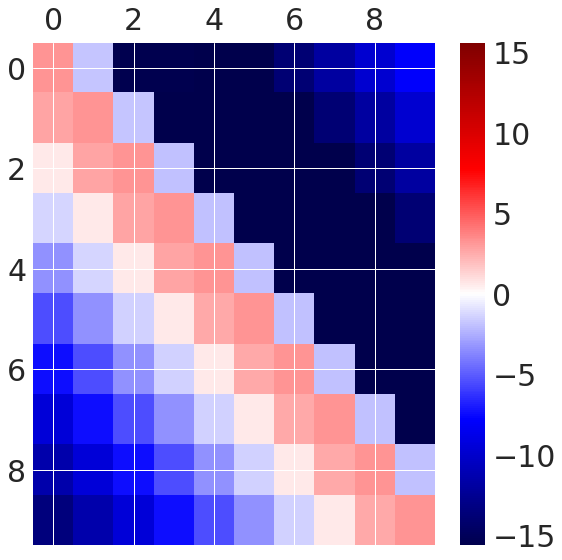

In [70]:
w = dic['w']

symmetric = np.max((np.max(w), np.abs(np.min(w))))
plt.matshow(w, aspect='auto', vmin=-symmetric, vmax=symmetric, cmap='seismic')
plt.colorbar();

In [65]:
def train_network_BCPNN_z(N, dt, training_time, inter_sequence_time, sequences, tau_z, tau_z_post, tau_p,
                          epochs=1, max_w=1.0, min_w=None, save_w_history=False):

    w = np.zeros((N, N))
    w_history = [w]

    inter_sequence_steps = int(inter_sequence_time / dt)

    x_total = np.array([]).reshape(0, N)
    for epoch in range(epochs):
        for sequence in sequences:
            n_sequence = len(sequence)
            training_steps = int(training_time / dt)

            for element in sequence:
                x = np.zeros((training_steps, N))
                for time in range(training_steps):
                    x[time, element] = 1.0
                # Concatenate for the total history
                x_total = np.concatenate((x_total, x), axis=0)

            # Inter-sequence steps
            x = np.zeros((inter_sequence_steps, N))
            x_total = np.concatenate((x_total, x), axis=0)

    # Train the Z-filters and w
    z = np.zeros(N)
    z_post = np.zeros(N)
    z_co = np.zeros((N, N))
    p_pre = np.zeros(N) * (1.0 / N)
    p_post = np.zeros(N) * (1.0 / N)
    p_co = np.zeros((N, N)) * (1.0 / N)

    z_history = np.zeros_like(x_total)
    z_post_history = np.zeros_like(x_total)

    for index, x_example in enumerate(x_total):
        z += (dt / tau_z) * (x_example - z)
        z_post += (dt / tau_z_post) * (x_example - z_post)
        p_pre += (dt/ tau_p) * (z - p_pre)
        p_post += (dt/ tau_p) * (z_post - p_post)
        
        z_co = np.outer(z_post, z)
        p_co += (dt / tau_p) * (z_co - p_co)
        
        p = 1.0
        epsilon = 1e-10
        
        
        z_history[index, :] = z
        z_post_history[index, :] = z_post
        aux = get_w_pre_post(z_co, z, z_post, p=p, epsilon=epsilon, diagonal_zero=False)
        print(aux)
        w += (tau_p/ dt) * aux 

        if save_w_history:
            w_history.append(np.copy(w))

    
    dic = {}
    dic['w'] = w
    dic['x'] = x_total
    dic['z'] = z_history
    dic['z_post'] = z_post_history

    if save_w_history:
        dic['w_history'] = np.array(w_history)

    return dic

In [66]:
N = 10
dt = 0.001
training_time = 0.100
inter_sequence_time = 0.500
sequences = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
tau_z = 0.050
tau_z_post= 0.005
tau_p = 10.0

dic = train_network_BCPNN_z(N, dt, training_time, inter_sequence_time, sequences, tau_z, tau_z_post, tau_p,
                        epochs=3, max_w=1.0, min_w=None, save_w_history=False)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

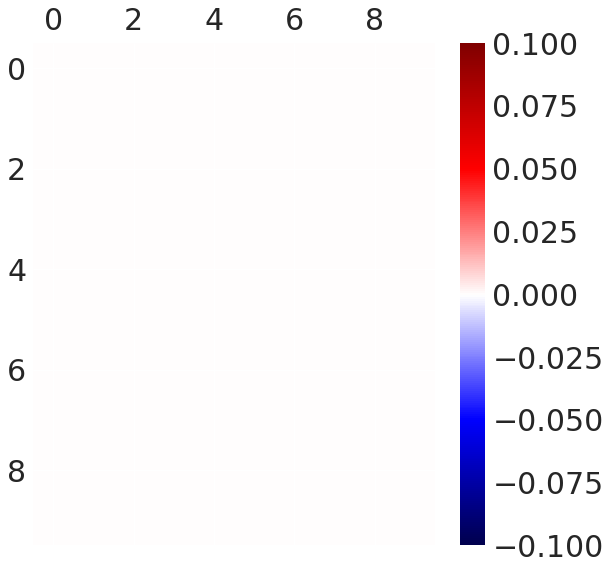

In [67]:
w = dic['w']

symmetric = np.max((np.max(w), np.abs(np.min(w))))
plt.matshow(w, aspect='auto', vmin=-symmetric, vmax=symmetric, cmap='seismic')
plt.colorbar();